In [1]:
import pandas as pd
import numpy as np
import pathlib
import json
import matplotlib.pyplot as plt
import requests
import pathlib

# If running locally, download the latest metrics from the IC Mainnet

In [2]:
!test -f ~/.config/dfx/identity/ic-fa3em/identity.pem && \
  dre --private-key-pem ~/.config/dfx/identity/ic-fa3em/identity.pem trustworthy-metrics nanx4-baaaa-aaaap-qb4sq-cai 0 > data.json

 INFO  dre > Running version 0.2.1-d1fe2c7
 INFO  ic_management_backend::registry > Using local registry path for network mainnet: /home/sat/.cache/ic-registry-cache/mainnet/local_registry
 INFO  ic_management_backend::git_ic_repo > IC git repo path: /home/sat/.cache/git/ic, lock file path: /home/sat/.cache/git/ic.lock
 INFO  ic_management_backend::registry    > Found 6 branches for git rev: a7862784e8da4a97a1d608fd5b3db365de41a2d7
 INFO  ic_management_backend::registry    > Found 9 branches for git rev: fed4316368b93245120ceb0596423c715bb31ff0
 WARN  ic_management_backend::registry    > branch fed4316368b93245120ceb0596423c715bb31ff0 for git rev gary/bare-metal-ci-job does not match RC regex
 INFO  ic_management_backend::registry    > Found 1 branches for git rev: 072b2a6586c409efa88f2244d658307ff3a645d8
 INFO  ic_management_backend::registry    > Found 40 branches for git rev: ec140b74dc4fef2f4bee3fad936e315380fa5af3
 WARN  ic_management_backend::registry    > branch ec140b74dc4fef2f

# Load data

In [3]:
data_json = pathlib.Path("data.json")
if not data_json.exists():
    contents = requests.get("https://github.com/dfinity/dre/raw/main/docs/trustworthy-metrics/data.json").text
    data_json.write_text(contents)
data = json.load(pathlib.Path("data.json").open())
data_flat = []
for subnet_id, subnet_data in data.items():
    node_last_entry = {}
    for day in subnet_data:
        ts_nanos = day["timestamp_nanos"]
        day_data = day["node_metrics"]
        for entry in day_data:
            node_id = entry["node_id"]
            # Calculate diff (increase) from the entry with the previous timestamp
            prev_entry = node_last_entry.get(node_id, {})
            if entry["num_blocks_total"] == 0 or not prev_entry:
                entry["num_blocks_diff"] = 0
                entry["num_block_failures_diff"] = 0
            else:
                entry["num_blocks_diff"] = entry["num_blocks_total"] - prev_entry.get("num_blocks_total", 0)
                entry["num_block_failures_diff"] = entry["num_block_failures_total"] - prev_entry.get("num_block_failures_total", 0)
            node_last_entry[node_id] = entry
            entry["subnet_id"] = subnet_id
            entry["timestamp_nanos"] = ts_nanos
            data_flat.append(entry)
df = pd.json_normalize(data_flat)
df["date"] = pd.to_datetime(df["timestamp_nanos"]).dt.round("D")
df["node_failed_rounds_percent"] = (df["num_block_failures_diff"] * 100 / (df["num_blocks_diff"]+df["num_block_failures_diff"])).replace(np.inf, 0).fillna(0)

# How many days of metrics do we have?

In [4]:
len(df["date"].unique())

59

# Show the DataFrame sorted by "node_failed_rounds_percent"

In [5]:
df.sort_values("node_failed_rounds_percent")

,node_id,num_blocks_total,num_block_failures_total,num_blocks_diff,num_block_failures_diff,subnet_id,timestamp_nanos,date,node_failed_rounds_percent
0,3ppfv-vqufk-yrg2j-nos4h-6fxos-iucst-jsf7h-be4f...,65378,3089,0,0,3hhby-wmtmw-umt4t-7ieyg-bbiig-xiylg-sblrt-voxg...,1701561599308218775,2023-12-03,0.0
20125,vhw72-z4xlu-g2ee2-7owc7-6qk6u-j6jhm-cfzk4-2jty...,470889,474,7940,0,ejbmu-grnam-gk6ol-6irwa-htwoj-7ihfl-goimw-hlnv...,1706054399252105983,2024-01-24,0.0
7083,4ifvf-q4djg-kzooi-5xvs6-66adz-6mysk-c2bz6-osui...,42233,252,2267,0,uzr34-akd3s-xrdag-3ql62-ocgoh-ld2ao-tamcv-54e7...,1702166398758045667,2023-12-10,0.0
20124,bayvy-p36kq-krz3d-o5lay-rxx3w-h35pc-235tv-mmhf...,471253,493,7892,0,ejbmu-grnam-gk6ol-6irwa-htwoj-7ihfl-goimw-hlnv...,1706054399252105983,2024-01-24,0.0
7085,5cphe-ynceg-ybsv7-5fpo7-rxte2-hbmm6-wkren-7lyf...,42082,205,2276,0,uzr34-akd3s-xrdag-3ql62-ocgoh-ld2ao-tamcv-54e7...,1702166398758045667,2023-12-10,0.0
...,...,...,...,...,...,...,...,...,...
24841,ehizo-zv4le-hkzuy-gqyvw-6enab-mazoj-p57ci-kese...,221083,9840,0,5716,k44fs-gm4pv-afozh-rs7zw-cg32n-u7xov-xqyx3-2pw5...,1703548799615508191,2023-12-26,100.0
24834,yuhde-ypx4v-v7kmi-z3wye-fcd2n-ztakc-7ahvu-rn66...,170512,47653,0,2640,k44fs-gm4pv-afozh-rs7zw-cg32n-u7xov-xqyx3-2pw5...,1703462399261642142,2023-12-25,100.0
4965,r5i76-zvt2k-ssuo3-on5tn-gl7fr-vvx3g-mits2-inmh...,227984,64403,0,6729,csyj4-zmann-ys6ge-3kzi6-onexi-obayx-2fvak-zers...,1704153599613121951,2024-01-02,100.0
24880,ehizo-zv4le-hkzuy-gqyvw-6enab-mazoj-p57ci-kese...,221083,26954,0,5653,k44fs-gm4pv-afozh-rs7zw-cg32n-u7xov-xqyx3-2pw5...,1703807999409662811,2023-12-29,100.0


# Count number of days per node, for which the node failed to be productive in 10% or more block rounds per day

In [6]:
df[df["node_failed_rounds_percent"] > 10].groupby("node_id").node_id.count().sort_values()

node_id
dkx5h-i5d56-xeb37-uldi5-dlgmp-atrom-gyfn7-edeih-i5ph6-2cquy-dqe     1
7exbb-k4tu4-mw24y-3zylh-bopa5-fwdsc-f4a3z-45hh4-twpin-4zv4a-yae     1
6qxes-2iftw-fq3we-unkdt-y7wnk-4v26t-fftzu-chgeh-t2ljb-qtevx-iae     1
nxeqo-y6jk3-5zpcu-waryv-lz3ha-c2iuu-jljee-yzew7-jo5dk-6dgr7-3qe     1
4vpak-qnqtn-vggke-um4f2-zkk2m-awc6p-bkhi5-cm22y-zhdiz-yx5rt-cqe     1
                                                                   ..
h7abv-ipt46-s3pz3-pzbaz-lw63i-7zgtk-u7hp2-gjcbq-orou3-nxrjy-lae    16
xgqku-jngij-orvvf-s6ywy-t2ldf-6x3tv-ekdjg-f6ww5-oczmh-k6r54-2ae    16
ehizo-zv4le-hkzuy-gqyvw-6enab-mazoj-p57ci-kesea-4ufju-d3jv4-oae    16
r5i76-zvt2k-ssuo3-on5tn-gl7fr-vvx3g-mits2-inmhe-ohouc-ebdik-3qe    16
ul75e-6e3ls-pno2p-y3plc-cd2gq-dfnw4-56woc-s45vm-ipu6u-lotli-uae    18
Name: node_id, Length: 75, dtype: int64

# Sanity check: give records for which more than 100% of rounds were non-productive (should be empty always)

In [7]:
df[df["node_failed_rounds_percent"] > 100]

,node_id,num_blocks_total,num_block_failures_total,num_blocks_diff,num_block_failures_diff,subnet_id,timestamp_nanos,date,node_failed_rounds_percent


# Plots

## Plot all records in which nodes were unproductive for more than 10% of time

<Figure size 640x480 with 0 Axes>

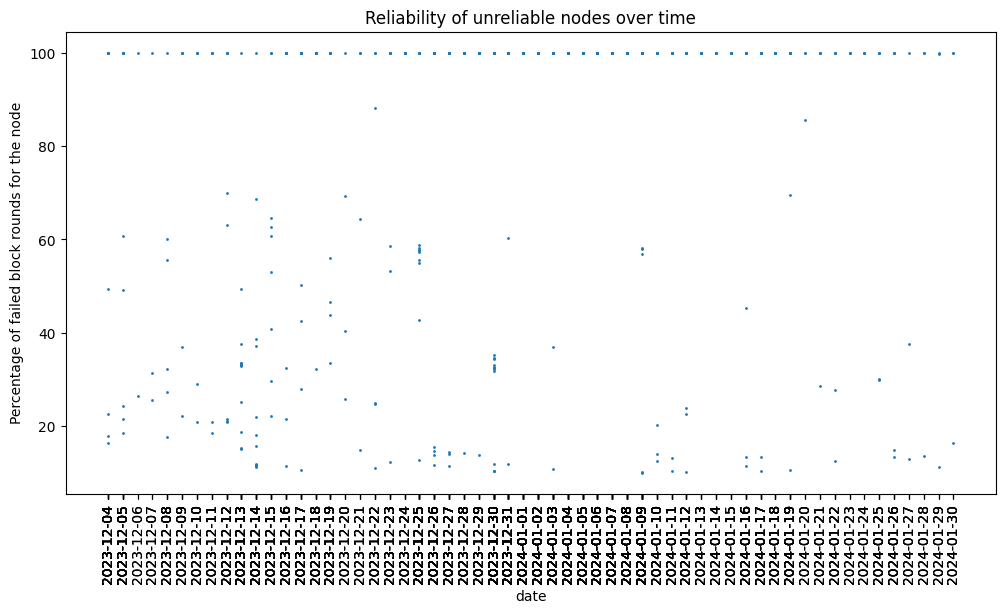

In [12]:
plt.figure()
df10 = df[df["node_failed_rounds_percent"] > 10]
ax = df10.plot(kind="scatter", x='date', y='node_failed_rounds_percent', ylabel="Percentage of failed block rounds for the node", title="Reliability of unreliable nodes over time", figsize=(12, 6), s=1)
plt.xticks(df10["date"], rotation=90)
plt.show()

## Plot percentage of failed block rounds for a particular node id

In [9]:
from ipywidgets import interact, widgets

node_ids_widget = widgets.Combobox(
    placeholder='Type a node id',
    options=list(df["node_id"].unique()),
    description='Combobox:',
    ensure_option=True,
    disabled=False
)

# display(node_ids_widget)

@interact(node_id = node_ids_widget)
def plot_node_id(node_id):
    if node_id:
        df_node = df[df["node_id"] == node_id]
        df_node.plot(kind="scatter", x='date', y='node_failed_rounds_percent', ylabel="Percentage of blocks", title="Percentage of blocks for which node failed to propose a block", figsize=(12, 6), s=1)
        plt.xticks(df_node["date"], rotation=90)
        plt.show()


interactive(children=(Combobox(value='', description='Combobox:', ensure_option=True, options=('3ppfv-vqufk-yr…

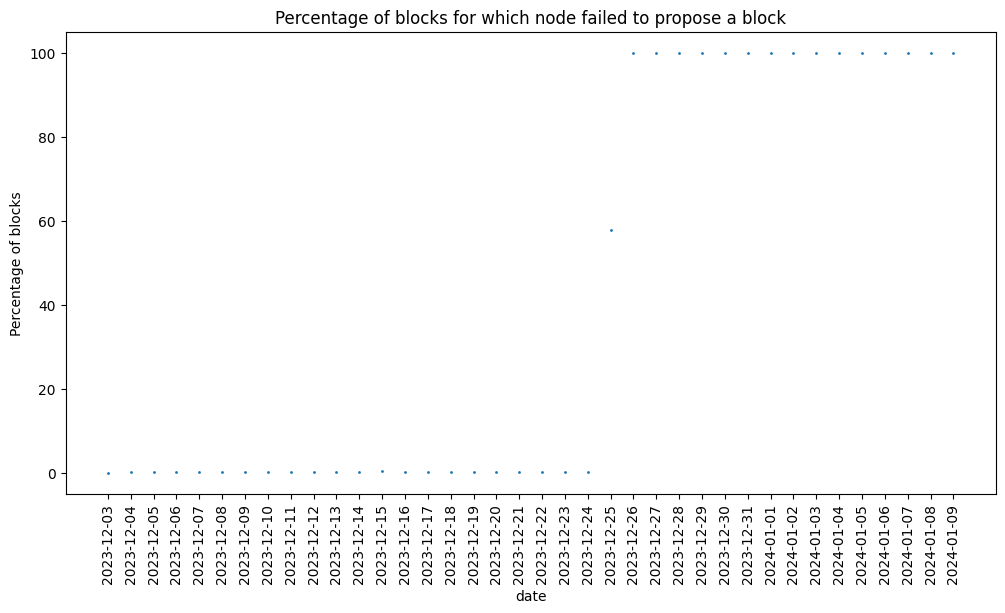

In [10]:
df_node = df[df["node_id"] == "r5i76-zvt2k-ssuo3-on5tn-gl7fr-vvx3g-mits2-inmhe-ohouc-ebdik-3qe"]
df_node.plot(kind="scatter", x='date', y='node_failed_rounds_percent', ylabel="Percentage of blocks", title="Percentage of blocks for which node failed to propose a block", figsize=(12, 6), s=1)
plt.xticks(df_node["date"], rotation=90)
plt.show()